# Data Preparation for YOLO

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import cv2
import math
import numpy as np
from sklearn.cluster import KMeans

In [2]:
with open("./annotations.json", "r") as f:
    data = json.load(f)

In [3]:
import os
images_dir = "./images"

In [4]:
annots_data = []
for file, value in data.items():
    filename = value["filename"]
    height, width, channels = cv2.imread(os.path.join(images_dir,filename)).shape

    for region in value["regions"]:
        x = region["shape_attributes"]['x']
        y = region["shape_attributes"]['y']
        w = region["shape_attributes"]['width']
        h = region["shape_attributes"]['height']
        class_ = region["region_attributes"]["animal"]

        annots_data.append({'filename':filename, 'class':class_, 'height':height, 'width':width, 'x':x, 'y':y, 'w':w, 'h':h})
        

In [5]:
annots_df = pd.DataFrame(annots_data)

In [6]:
# calculate center co-ordinates of bounding box
annots_df["cx"] = (2*annots_df["x"] + annots_df["w"])//2
annots_df["cy"] = (2*annots_df["y"] + annots_df["h"])//2

In [7]:
annots_df.head()

,filename,class,height,width,x,y,w,h,cx,cy
0,dog001.jpg,dog,426,640,263,30,112,103,319,81
1,dog002.jpg,dog,426,640,303,11,272,404,439,213
2,dog003.jpg,dog,426,640,195,48,294,378,342,237
3,dog004.jpg,dog,426,640,321,153,140,120,391,213
4,dog005.jpg,dog,423,640,244,157,154,187,321,250


In [8]:
annots_df.shape

(59, 10)

In [9]:
# plot images and bounding box
def plot_image(series):
    fig,ax = plt.subplots(1)
    ax.imshow(cv2.imread(os.path.join(images_dir, series["filename"])))
    rect = patches.Rectangle((series['x'],series['y']),series['w'],series['h'],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.plot(series["cx"],series["cy"], 'ro')
    plt.show()

In [10]:
dog_sample = annots_df.iloc[25]
dog_sample

filename    dog024.jpg
class              dog
height             424
width              640
x                  246
y                   78
w                  198
h                  326
cx                 345
cy                 241
Name: 25, dtype: object

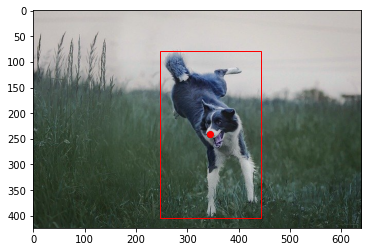

In [11]:
plot_image(dog_sample)

Here, bounding `box is red` in color and the `red dot` represents center coordinates of bounding box.

(0,0) index is top-left corner of the image, (640,424) is bottom-right corner.<br />
(246,78) is top-left corner of bounding box, width of bbox is 198, height of bbox is 326. <br />
(345, 241) is center coordinate of bounding box.


## PROCESSING DATA 

### Normalize data

In [12]:
annots_df.head()

,filename,class,height,width,x,y,w,h,cx,cy
0,dog001.jpg,dog,426,640,263,30,112,103,319,81
1,dog002.jpg,dog,426,640,303,11,272,404,439,213
2,dog003.jpg,dog,426,640,195,48,294,378,342,237
3,dog004.jpg,dog,426,640,321,153,140,120,391,213
4,dog005.jpg,dog,423,640,244,157,154,187,321,250


In [13]:
annots_df["norm_width"] = annots_df["width"]/annots_df["width"]
annots_df["norm_height"] = annots_df["height"]/annots_df["height"]
annots_df["norm_w"] = annots_df["w"]/annots_df["width"]
annots_df["norm_h"] = annots_df["h"]/annots_df["height"]


In [14]:
annots_df.head()

,filename,class,height,width,x,y,w,h,cx,cy,norm_width,norm_height,norm_w,norm_h
0,dog001.jpg,dog,426,640,263,30,112,103,319,81,1.0,1.0,0.175000,0.241784
1,dog002.jpg,dog,426,640,303,11,272,404,439,213,1.0,1.0,0.425000,0.948357
2,dog003.jpg,dog,426,640,195,48,294,378,342,237,1.0,1.0,0.459375,0.887324
3,dog004.jpg,dog,426,640,321,153,140,120,391,213,1.0,1.0,0.218750,0.281690
4,dog005.jpg,dog,423,640,244,157,154,187,321,250,1.0,1.0,0.240625,0.442080


Now, in YOLO if we divide our image in 13 blocks, we need to calculate in which block bounding box center coordinate will fall in ?

In [15]:
def plot_image(series, n=6):
    fig,ax = plt.subplots(1)
    im = cv2.imread(os.path.join(images_dir, series["filename"]))
    dh, dw = im.shape[0]//n+1, im.shape[1]//n+1
    grid_color = [255,255,255]
    
    im[:,::dw,:] = grid_color
    im[::dh,:,:] = grid_color

    ax.imshow(im)
    
    rect = patches.Rectangle((series['x'],series['y']),series['w'],series['h'],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.plot(series["cx"],series["cy"], 'ro')
    plt.show()

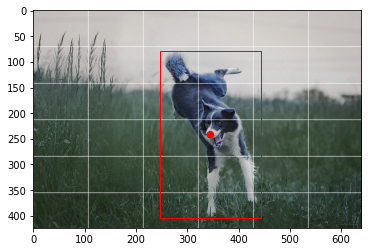

In [16]:
plot_image(dog_sample)

In [17]:
annots_df["block_x"] = annots_df["cx"]//(annots_df["width"]//6) + 1
annots_df["block_y"] = annots_df["cy"]//(annots_df["height"]//6) + 1

In [18]:
annots_df.iloc[25]

filename       dog024.jpg
class                 dog
height                424
width                 640
x                     246
y                      78
w                     198
h                     326
cx                    345
cy                    241
norm_width              1
norm_height             1
norm_w           0.309375
norm_h           0.768868
block_x                 4
block_y                 4
Name: 25, dtype: object

Now, we can see our center coordinate for above image falls in (4,4) block.

## FINDING CLUSTERS FOR OUR TEMPLATE BOXES TO USE

We will use norm_w and norm_h to find number of clusters

In [115]:
bbox_data = annots_df[["norm_w","norm_h"]]

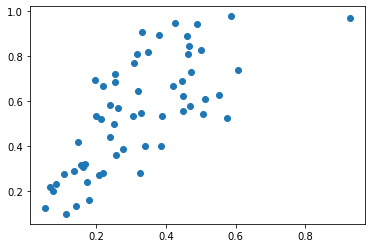

In [116]:
plt.scatter(bbox_data["norm_w"], bbox_data["norm_h"])

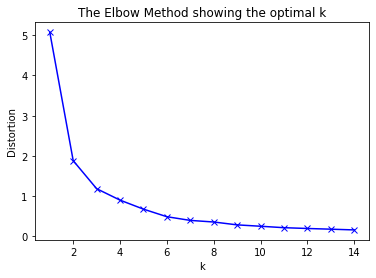

In [117]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(bbox_data)
    distortions.append(kmeanModel.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can observe that the “elbow” is the number 6 which is optimal for this case.

### Calculation of Mean IOU

template box width and height are the centroids for clusters we will get from kmeans.

IOU = (intersection area of bbox and template box)/(union area of bbox and template box)

bw = bounding box width, <br>
bh = bounding box height <br>
aw = template box width, <br>
ah = template box height <br>

`IOU = ( min(bw,aw) * min(bh, ah) ) / ( bw*bh + aw*ah - ( min(bw,aw) * min(bh, ah) ) )`

`mean IOU = sum(IOU)/len(num_of_instances)`

In [454]:
sample_dog_index = 6

In [455]:
df = bbox_data[["norm_w","norm_h"]]

bbox_heights = df["norm_h"].values
bbox_widths = df["norm_w"].values
 

mean_iou = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)

    iou = []
    for i in range(df.shape[0]):
        l = kmeanModel.labels_[i]
        bcx = kmeanModel.cluster_centers_[l][0]
        bcy = kmeanModel.cluster_centers_[l][1]

        if i==sample_dog_index:
            sample_dog_bcx = bcx
            sample_dog_bcy = bcy

        intersection = (min(bbox_widths[i],bcx) * min(bbox_heights[i],bcy))
        union = bbox_widths[i]*bbox_heights[i] + bcx*bcy - intersection
        iou.append(intersection/union)
    mean_iou.append(sum(iou)/df.shape[0])

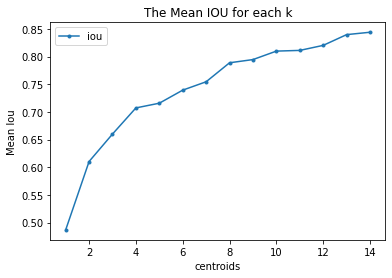

In [456]:
plt.plot(range(1,15),mean_iou,'.-',label = "iou")
plt.xlabel('centroids')
plt.ylabel('Mean Iou')
plt.title('The Mean IOU for each k')
plt.legend()
plt.show()

In [457]:
mean_iou[6]

0.7544412257993945

from elbow method we calculated 6/7 as optimal clusters.

from mean IOU for number of centroids, for 7 centroids we get > 75% 

#### Let's run clustering algorithm for n=7

Text(0.5, 1.0, 'K_Means')

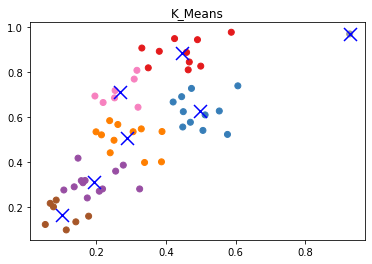

In [458]:
n = 7
kmeanModel = KMeans(n_clusters=n)
kmeanModel.fit(bbox_data)

bbox_data['k_means'] = kmeanModel.predict(bbox_data)
centroids = kmeanModel.cluster_centers_
fig, axes = plt.subplots(1)
axes.scatter(bbox_data["norm_w"], bbox_data["norm_h"], c=bbox_data['k_means'], cmap=plt.cm.Set1)
axes.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='b', zorder=10)
axes.set_title('K_Means')

### DRAW CALCULATED TEMPLATE BOX AND ACTUAL BOUNDING BOX for sample dog

In [459]:
sdog = annots_df.iloc[sample_dog_index]
sdog

filename       dog007.jpg
class                 dog
height                416
width                 640
x                     259
y                     123
w                     354
h                     261
cx                    436
cy                    253
norm_width              1
norm_height             1
norm_w           0.553125
norm_h           0.627404
block_x                 5
block_y                 4
Name: 6, dtype: object

In [460]:
sdog["block_x"] = sdog["cx"]//(sdog["width"]//n) + 1
sdog["block_y"] = sdog["cy"]//(sdog["height"]//n) + 1

In [461]:
sdog["block_xtl"] = (sdog["block_x"]-1)*(sdog["width"]//n)
sdog["block_ytl"] = (sdog["block_y"]-1)*(sdog["height"]//n)

sdog["block_cx"] = sdog["block_xtl"] + ((sdog["width"]//n)//2)
sdog["block_cy"] = sdog["block_ytl"] + ((sdog["height"]//n)//2)

sdog["template_w"] = sample_dog_bcx * sdog["width"]
sdog["template_h"] = sample_dog_bcy * sdog["height"]
sdog["template_x"] = sdog["block_cx"] - (sdog["template_w"]//2)
sdog["template_y"] = sdog["block_cy"] - (sdog["template_h"]//2)

In [462]:
sdog

filename       dog007.jpg
class                 dog
height                416
width                 640
x                     259
y                     123
w                     354
h                     261
cx                    436
cy                    253
norm_width              1
norm_height             1
norm_w           0.553125
norm_h           0.627404
block_x                 5
block_y                 5
block_xtl             364
block_ytl             236
block_cx              409
block_cy              265
template_w            371
template_h        284.189
template_x            224
template_y            123
Name: 6, dtype: object

In [463]:
def plot_image(series, n=7):
    fig,ax = plt.subplots(1)
    im = cv2.imread(os.path.join(images_dir, series["filename"]))
    dh, dw = im.shape[0]//n+1, im.shape[1]//n+1
    grid_color = [255,255,255]
    
    im[:,::dw,:] = grid_color
    im[::dh,:,:] = grid_color

    ax.imshow(im)
    
    rect1 = patches.Rectangle((series['x'],series['y']),series['w'],series['h'],linewidth=1,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle((series['template_x'],series['template_y']),series['template_w'],series['template_h'],linewidth=2,edgecolor='y',facecolor='none')
    
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    plt.plot(series["cx"],series["cy"], 'ro')
    plt.show()

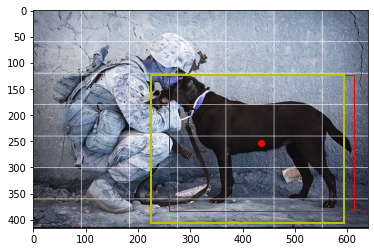

In [464]:
plot_image(sdog, n)